# Iris eye Recognition

## Firstly, we will import all required libraries

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rd
import math
from PIL import Image

## Then let's have a look into the datasets

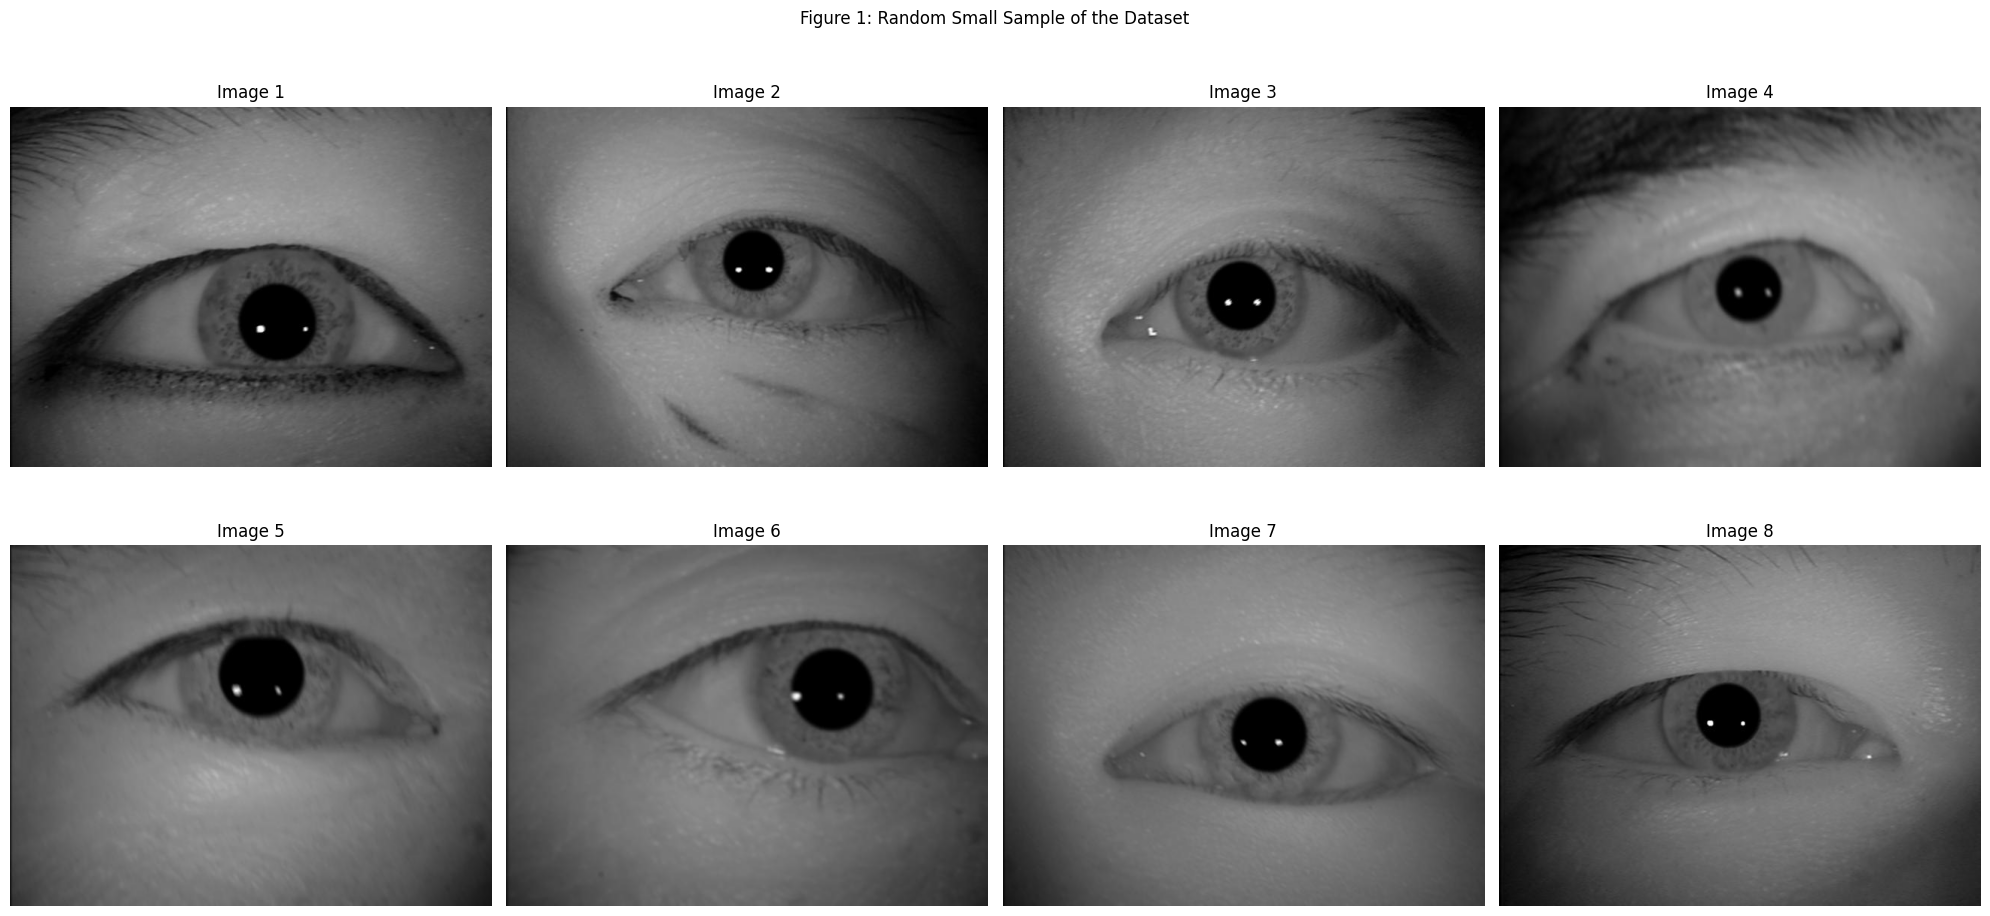

In [24]:
def show_random_samples(dataset_dir, num):
    # Get all image paths in the dataset directory
    image_paths = []
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):  # Adjust if you have a different image format
                image_paths.append(os.path.join(root, file))
    
    # Randomly select 'num' images
    rd.seed(1190652)
    random_indices = rd.sample(range(len(image_paths)), num)
    
    # Determine the number of rows for subplots (4 images per row)
    num_rows = math.ceil(num / 4)
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))
    
    for i, idx in enumerate(random_indices):
        row = i // 4
        col = i % 4
        
        # Load and display the image
        image_path = image_paths[idx]
        image = Image.open(image_path)
        image_rgb = image.convert("RGB")
        
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(image_rgb)
        ax.set_title(f"Image {i + 1}")
        ax.axis("off")

    plt.suptitle("Figure 1: Random Small Sample of the Dataset")
    plt.tight_layout()
    plt.show()

# Example usage
dataset_dir = r'dataset'  
show_random_samples(dataset_dir, 8)

- Some eyes uses eyeliner.
- Some eyes interval are big.
- Some eyes intervals are small.
- The images are greyscaled.

## Localization


### Gaussian and Bilateral Filter are mostly used for enhancing image for iris detection, so we will try these first

### 1) Gaussian

Firstly, we will use Gaussian Blur to smooth out the image and remove high-frequency noise that might interfere with Hough Circle Detection

In [4]:

def localization_Gauss(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        circles = cv2.HoughCircles(
            gray_blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    


For the multiple processing at a time, I will use a loop function to looping through all 10000 images in the datasets

In [5]:
def iterate_dataset_localization(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_Gauss(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization(dataset_path)

C:\Users\Kim Duy Minh\AppData\Local\Temp\ipykernel_28472\1526325327.py:22: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)


Error files: 
dataset\019\S6019S07.jpg
dataset\021\S6021S03.jpg
dataset\021\S6021S05.jpg
dataset\021\S6021S08.jpg
dataset\021\S6021S09.jpg
Number of images: 10000
Number of errors: 452


Quite a good output though, only failed 4.5%

Let's have a look at those error images.

Image 1 size: (640, 480), Mode: RGB
Image 2 size: (640, 480), Mode: RGB
Image 3 size: (640, 480), Mode: RGB
Image 4 size: (640, 480), Mode: RGB
Image 5 size: (640, 480), Mode: RGB


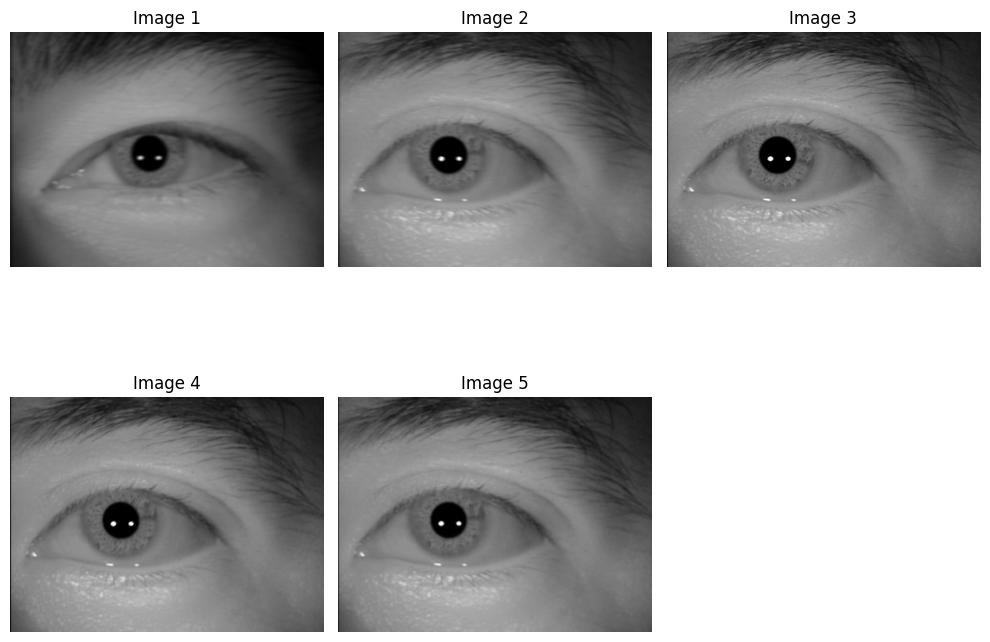

In [27]:
image_paths = [
    r'dataset\019\S6019S07.jpg',
    r'dataset\021\S6021S03.jpg',
    r'dataset\021\S6021S05.jpg',
    r'dataset\021\S6021S08.jpg',
    r'dataset\021\S6021S09.jpg'
]

# Create a figure to display multiple images
plt.figure(figsize=(10, 8))

# Loop through each image path and display the image
for i, image_path in enumerate(image_paths, 1):
    # Open the image using PIL
    try:
        image = Image.open(image_path)
        
        # Check if the image is in RGBA or another mode and convert it to RGB
        if image.mode != 'RGB':
            image = image.convert('RGB')
    except Exception as e:
        print(f"Failed to load image at: {image_path}. Error: {e}")
        continue

    # Debugging: Check the image mode and size
    print(f"Image {i} size: {image.size}, Mode: {image.mode}")  # Should be RGB for color images

    # Add the image to the subplot
    plt.subplot(2, 3, i)  # 2 rows, 3 columns, i-th image
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    plt.title(f"Image {i}")

# Display the images
plt.tight_layout()
plt.show()

These images mostly being blurred by the quality of the sensors, so I will try apply multiple image processing method to improve the quality. We will try some combination of image processing method instead of using only one like this

### 2)Multiple combination
#### a)CLAHE + Gaussian Blur:

In [7]:

def localization_Gauss_CLAHE(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        gray_blurred = cv2.equalizeHist(blurred)
        
        circles = cv2.HoughCircles(
            gray_blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

Then we iterate through the dataset 1 more time

In [8]:
def iterate_dataset_localization_Gauss_CLAHE(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_Gauss_CLAHE(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_Gauss_CLAHE(dataset_path)

C:\Users\Kim Duy Minh\AppData\Local\Temp\ipykernel_28472\3478806394.py:24: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)


Error files: 
dataset\000\S6000S00.jpg
dataset\000\S6000S01.jpg
dataset\000\S6000S05.jpg
dataset\000\S6000S09.jpg
dataset\002\S6002S00.jpg
Number of images: 10000
Number of errors: 878


The result is even worst 

#### b)Sharpening filter

In [9]:

def localization_sharpening_filter(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sharpening_kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])

        gray_sharpened= cv2.filter2D(gray, -1, sharpening_kernel)
        blurred = cv2.GaussianBlur(gray_sharpened, (5, 5), 2)
        
        
        circles = cv2.HoughCircles(
            blurred,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

Let's iterate through the dataset one more time

In [11]:
def iterate_dataset_localization_sharpening(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_sharpening_filter(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_sharpening(dataset_path)

C:\Users\Kim Duy Minh\AppData\Local\Temp\ipykernel_28472\1031337455.py:26: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)


Error files: 
dataset\000\S6000S05.jpg
dataset\000\S6000S07.jpg
dataset\000\S6000S08.jpg
dataset\000\S6000S09.jpg
dataset\001\S6001S01.jpg
Number of images: 10000
Number of errors: 3509


Still bad performance, let's try another one

#### c)Histogram Equalization + Gaussian Blur

In [12]:

def localization_HisEqualGauss(image):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 2)
        equalized = cv2.equalizeHist(blurred)
        
        
        circles = cv2.HoughCircles(
            equalized,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=60,
            param2=30,
            minRadius=40,
            maxRadius=100
        )
        if circles is not None:
            circles = np.uint16(np.around(circles))
            x = circles[0][0][0]
            y = circles[0][0][1]
            r = circles[0][0][2]
            zoom_out_factor = 1
            crop_size = int(r * zoom_out_factor * 2)
            x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)
            x2, y2 = min(x + crop_size, image.shape[1]), min(y + crop_size, image.shape[0])

            cropped_image = image[y1:y2, x1:x2]
            resized_image = cv2.resize(cropped_image, (224, 224))
            return resized_image
        else:
            #print("No circles detected.")
            return None
    except Exception as e:
        #print(e)
        a=0 
    

In [13]:
def iterate_dataset_localization_HisEquaL_Gauss(dataset_path):
    num_of_pics = 0
    num_of_err = 0
    error_ids=[]
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):  # Adjust for your image format
                num_of_pics+=1
                try:
                    image_path = os.path.join(root, file)
                    id_number = os.path.basename(root)  # Extract the ID number from the folder name
                    image = cv2.imread(image_path)
                    resized_image=localization_HisEqualGauss(image)
                # Process the image and ID number as needed
                    #print(f"Processing image: {image_path}, ID: {id_number}")
                # Extract ID and filename
                    id_dir, filename = os.path.split(image_path)
                    id_number = os.path.basename(id_dir)

                # Create the output directory if it doesn't exist
                    output_dir = os.path.join("processed_image", id_number)
                    os.makedirs(output_dir, exist_ok=True)

                # Construct the output filename
                    output_filename = os.path.join(output_dir, filename)
                    cv2.imwrite(output_filename, resized_image)
                except Exception as e:
                    #print(f"Error processing image: {image_path}, ID: {id_number}, Error: {e}")
                    num_of_err+=1
                    error_ids.append(image_path)
    print("Error files: ")
    for i in range(0,5):
        print(error_ids[i])
    print("Number of images: "+str(num_of_pics))
    print("Number of errors: "+str(num_of_err))
dataset_path = "dataset"
iterate_dataset_localization_HisEquaL_Gauss(dataset_path)

C:\Users\Kim Duy Minh\AppData\Local\Temp\ipykernel_28472\518574732.py:25: RuntimeWarning: overflow encountered in scalar subtract
  x1, y1 = max(x - crop_size, 0), max(y - crop_size, 0)


Error files: 
dataset\000\S6000S00.jpg
dataset\000\S6000S01.jpg
dataset\000\S6000S05.jpg
dataset\000\S6000S09.jpg
dataset\002\S6002S00.jpg
Number of images: 10000
Number of errors: 878


##### After several tries, the Gaussian method to improving the recognition of Iris using Hough Circle gives the best performance. Let's moving on to normalization step.

Result:

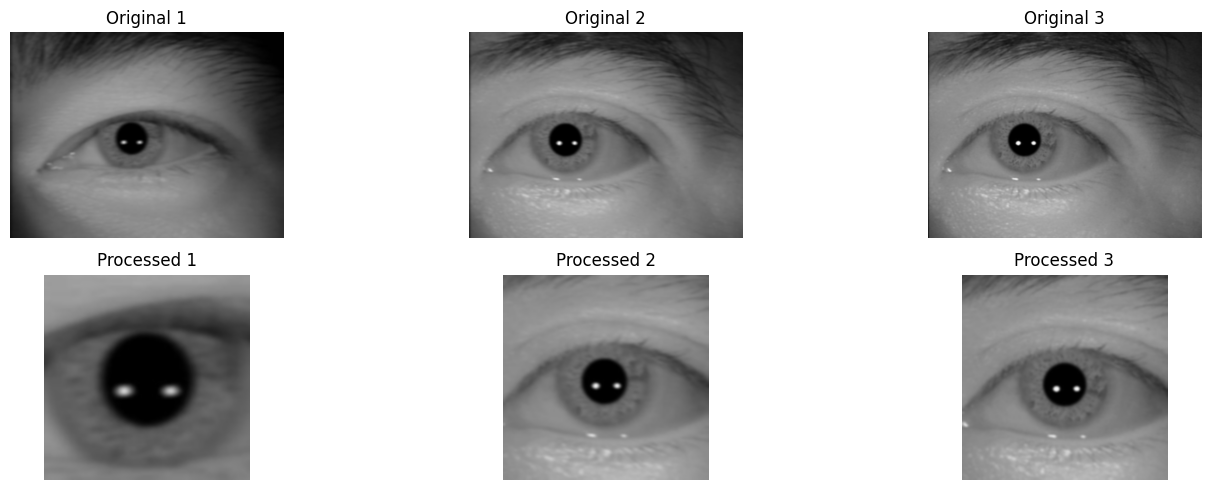

In [28]:
def load_and_process_image(image_path):
    image = cv2.imread(image_path)
    if image is None: 
        print(f"Error loading image: {image_path}")
        return None
    return cv2.cvtColor(cv2.GaussianBlur(image, (5, 5), 0), cv2.COLOR_BGR2RGB)

def display_images(non_processed_paths, processed_paths):
    plt.figure(figsize=(15, 5))
    for i, (orig_path, proc_path) in enumerate(zip(non_processed_paths, processed_paths)):
        orig_image, proc_image = load_and_process_image(orig_path), load_and_process_image(proc_path)
        if orig_image is None or proc_image is None:
            continue
        # Display original and processed images in subplots
        plt.subplot(2, len(non_processed_paths), i + 1)
        plt.imshow(orig_image), plt.axis('off'), plt.title(f"Original {i+1}")
        plt.subplot(2, len(non_processed_paths), len(non_processed_paths) + i + 1)
        plt.imshow(proc_image), plt.axis('off'), plt.title(f"Processed {i+1}")
    plt.tight_layout()
    plt.show()

# Example usage
non_processed_paths = [
    r'dataset\019\S6019S07.jpg', 
    r'dataset\021\S6021S03.jpg',
    r'dataset\021\S6021S05.jpg'
]

processed_paths = [
    r'processed_image\019\S6019S07.jpg',  
    r'processed_image\021\S6021S03.jpg',
    r'processed_image\021\S6021S05.jpg'
]

# Display the images
display_images(non_processed_paths, processed_paths)